In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy.tokens import normalize_token_spacing

In [67]:
np.random.seed(73)

In [97]:
num_players = 200

In [69]:
batting_average = np.random.normal(0.28, 0.05, num_players)

In [70]:
batting_average = np.clip(batting_average, 0.2, 0.4)

In [71]:
AB = np.random.randint(300, 700, num_players)  # At-bats for the season

In [72]:
H = AB * batting_average # Hits

In [73]:
height = np.random.normal(72, 6, num_players)

In [74]:
Wind = np.random.uniform(-1.5, 1.5, num_players)  # Average wind factor affecting performance

In [75]:
RBIs =(H * 0.5) + (AB * 0.02) + (height * 0.01) + (Wind * 7) + np.random.normal(0, 10, num_players)

In [76]:
RBIs_rounded = np.round(RBIs)
H_rounded = np.round(H)
AB_rounded = np.round(AB)

In [77]:
data = pd.DataFrame({
    'AB': AB_rounded,                  # At-Bats
    'H': H_rounded,                    # Hits
    'Height': height,                # Slugging Percentage
    'Wind': Wind,              # Wind Factor
    'RBIs': RBIs_rounded               # Runs Batted In (Target)
})

In [78]:
data.head()

,AB,H,Height,Wind,RBIs
0,376,116.0,62.701802,-0.808492,51.0
1,681,263.0,71.947362,-0.082001,150.0
2,389,156.0,62.709885,1.104468,98.0
3,600,176.0,84.284214,-0.925590,81.0
4,339,70.0,76.561405,-0.832225,30.0


## **_Fitting the regression model before addressing multicollinearity_**

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [80]:
X = data[['AB', 'H', 'Height', 'Wind']]

In [81]:
y = data['RBIs']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
lr = LinearRegression()

In [84]:
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [85]:
y_pred = lr.predict(X_test)

In [86]:
from sklearn.metrics import mean_squared_error, r2_score

In [87]:
mse_before = mean_squared_error(y_test, y_pred)

In [88]:
r2_before = r2_score(y_test, y_pred)

In [89]:
print(f'Before Multicollinearity: MSE: {mse_before}, R2: {r2_before}')

Before Multicollinearity: MSE: 98.07232401250748, R2: 0.7693226668567783


## **_Correlation Matrix_**

In [90]:
corr_matrix = X.corr()

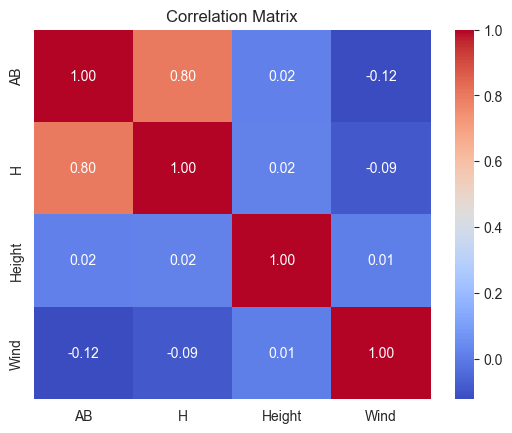

In [91]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## **_Variance Inflation Factor_**

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [93]:
vif_data = pd.DataFrame()

In [94]:
vif_data['Feature'] = X.columns

In [95]:
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [100]:
print(vif_data)

  Feature        VIF
0      AB  55.730459
1       H  40.140045
2  Height  18.550271
3    Wind   1.019001


## **_Condition Index_**

In [101]:
normalized_features = (X - X.mean()) / X.std()

In [102]:
cov_matrix = np.cov(normalized_features.T)

In [103]:
from numpy.linalg import eig

In [104]:
eigenvalues, _ = np.linalg.eig(cov_matrix)

In [105]:
condition_indices = np.sqrt(eigenvalues.max()/ eigenvalues)

In [106]:
ci_data = pd.DataFrame({'Condition_Index': condition_indices})

In [107]:
print(ci_data)

   Condition_Index
0         1.000000
1         3.041780
2         1.376878
3         1.347863


## **_Dropping a Feature_**

In [108]:
X_reduced = X[['H', 'Height', 'Wind']]

#### **_Look @ Correlation Matrix_**

In [109]:
corr_matrix = X_reduced.corr()

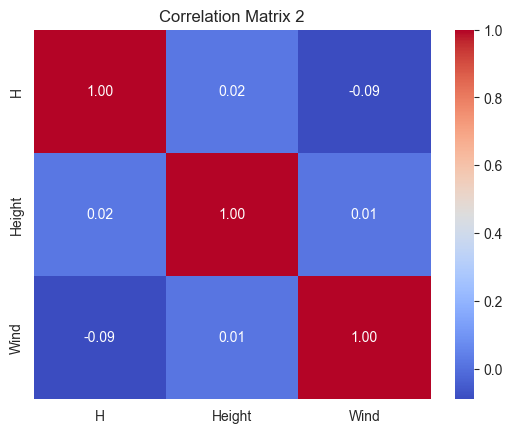

In [112]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix 2')
plt.show()

In [113]:
vif_data2 = pd.DataFrame()

In [115]:
vif_data2['Feature'] = X_reduced.columns

In [117]:
vif_data2["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

In [119]:
print(vif_data2)

  Feature        VIF
0       H  13.302478
1  Height  13.340842
2    Wind   1.012500


In [120]:
lr_reduced = LinearRegression()

In [121]:
lr_reduced.fit(X_train[['H', 'Height', 'Wind']], y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [122]:
y_pred_reduced = lr_reduced.predict(X_test[['H', 'Height', 'Wind']])

In [123]:
mse_reduced = mean_squared_error(y_test, y_pred_reduced)

In [124]:
r2_reduced = r2_score(y_test, y_pred_reduced)

In [126]:
print(f'Reduced: MSE: {mse_reduced}, R2: {r2_reduced}')

Reduced: MSE: 97.2417349184352, R2: 0.771276307489726


### **_Perform PCA_**

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca = PCA(n_components=3)  # Reduce to 3 components

In [130]:
X_train_pca = pca.fit_transform(X_train)

In [131]:
X_test_pca = pca.transform(X_test)

In [132]:
lr_pca = LinearRegression()

In [133]:
lr_pca.fit(X_train_pca, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [134]:
y_pred_pca = lr_pca.predict(X_test_pca)

In [135]:
mse_pca = mean_squared_error(y_test, y_pred_pca)

In [136]:
r2_pca = r2_score(y_test, y_pred_pca)

In [137]:
print(f'PCA: MSE: {mse_pca}, R2: {r2_pca}')

PCA: MSE: 106.0608695728561, R2: 0.75053269319082


### **_Ridge Regression_**

In [139]:
from sklearn.linear_model import Ridge

In [140]:
ridge = Ridge(alpha=1.0)

In [141]:
ridge.fit(X_train, y_train)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [142]:
y_pred_ridge = ridge.predict(X_test)

In [143]:
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

In [144]:
r2_ridge = r2_score(y_test, y_pred_ridge)

In [145]:
print(f'Ridge: MSE: {mse_pca}, R2: {r2_pca}')

Ridge: MSE: 106.0608695728561, R2: 0.75053269319082
